<a href="https://colab.research.google.com/github/CosmoVicky/FL_Challenge/blob/main/MultiWorkerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import os
import sys

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

In [ ]:
os.environ.pop('TF_CONFIG', None)

In [ ]:
if '.' not in sys.path:
  sys.path.insert(0, '.')

In [ ]:
%%writefile cifar.py

import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

def dataset(batch_size):
  (images, labels), _ = tf.keras.datasets.cifar10.load_data()
  # let's use 20% of train sample for validation
  sub_size = int(images.shape[0] * 0.2)

  validation_images, validation_labels = images[:sub_size], labels[:sub_size]
  train_images, train_labels = images[sub_size:], labels[sub_size:]

  train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
  validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

  train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
  val_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

  train_ds = (train_ds
                  .map(lambda x, y: (tf.image.per_image_standardization(x), y))
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=batch_size, drop_remainder=True))
  validation_ds = (validation_ds
                  .map(lambda x, y: (tf.image.per_image_standardization(x), y))
                  .shuffle(buffer_size=val_ds_size)
                  .batch(batch_size=batch_size, drop_remainder=True))
  return [train_ds, validation_ds]

def build_and_compile_model():
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=(32,32,3)),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation=tf.keras.activations.softmax)])
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    name='Adam'), metrics=['accuracy'])
  model.summary()
  return model

Writing cifar.py


In [ ]:
%%writefile main.py

import os
import json
import tensorflow as tf
import cifar

per_worker_batch_size = 40
tf_config = json.loads(os.environ['TF_CONFIG'])
num_workers = len(tf_config['cluster']['worker'])

strategy = tf.distribute.MultiWorkerMirroredStrategy()

global_batch_size = per_worker_batch_size * num_workers
multi_worker_dataset = cifar.dataset(global_batch_size)

model_path = '/tmp/keras-model'

def _is_chief(task_type, task_id):
  return (task_type == 'worker' and task_id == 0) or task_type is None

def _get_temp_dir(dirpath, task_id):
  base_dirpath = 'workertemp_' + str(task_id)
  temp_dir = os.path.join(dirpath, base_dirpath)
  tf.io.gfile.makedirs(temp_dir)
  return temp_dir

def write_filepath(filepath, task_type, task_id):
  dirpath = os.path.dirname(filepath)
  base = os.path.basename(filepath)
  if not _is_chief(task_type, task_id):
    dirpath = _get_temp_dir(dirpath, task_id)
  return os.path.join(dirpath, base)

task_type, task_id = (strategy.cluster_resolver.task_type,
                      strategy.cluster_resolver.task_id)
write_model_path = write_filepath(model_path, task_type, task_id)

with strategy.scope():
  multi_worker_model = cifar.build_and_compile_model()

multi_worker_model.fit(multi_worker_dataset[0], epochs=5, steps_per_epoch=100, validation_data=multi_worker_dataset[1],
    validation_freq=1)

multi_worker_model.save(write_model_path)

if not _is_chief(task_type, task_id):
  tf.io.gfile.rmtree(os.path.dirname(write_model_path))

Writing main.py


In [ ]:
%%bash
ls *.py

cifar.py
main.py


In [ ]:
tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456', 'localhost:34567']
    },
    'task': {'type': 'worker', 'index': 0}
}

In [ ]:
os.environ['TF_CONFIG'] = json.dumps(tf_config)

In [ ]:
os.environ

environ({'NO_GCE_CHECK': 'True', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', 'CUDA_VERSION': '11.1.1', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'SHLVL': '0', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.7.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '8.0.5.39', 'LAST_FORCED_REBUILD': '20210824', 'JPY_PARENT_PID': '50', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""],"debugAdapterMultiplexerPath":"/usr/local/bin/dap_multiplexer","enableLsp":true}', 'ENV': '/root/.bashrc', 'GLIBCXX_FORCE_NEW

In [ ]:
%killbgscripts

All background processes were killed.


**Run chief worker**

In [ ]:
%%bash --bg
python main.py &> job_0.log

Starting job # 0 in a separate thread.


In [ ]:
import time
time.sleep(10)

In [ ]:
%%bash
cat job_0.log

2021-09-17 22:03:32.661238: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-17 22:03:32.661329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e8b0182391e3): /proc/driver/nvidia/version does not exist
2021-09-17 22:03:32.760762: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> localhost:12345, 1 -> localhost:23456, 2 -> localhost:34567}
2021-09-17 22:03:32.761216: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:427] Started server with target: grpc://localhost:12345


In [ ]:
tf_config['task']['index'] = 1
os.environ['TF_CONFIG'] = json.dumps(tf_config)

**Set another home directory to avoid '.keras' cache conflict**

In [ ]:
%%bash --bg
HOME=$HOME/w1 python main.py &> job_1.log

Starting job # 2 in a separate thread.


In [ ]:
tf_config['task']['index'] = 2
os.environ['TF_CONFIG'] = json.dumps(tf_config)

In [ ]:
%%bash
HOME=$HOME/w2 python main.py

170508288/170498071 [==============================] - 11s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 96)        7296      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 256)         0         
______________________________________________________

In [ ]:
%%bash
cat job_0.log

2021-09-17 22:03:43.322325: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-17 22:03:43.322470: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e8b0182391e3): /proc/driver/nvidia/version does not exist
2021-09-17 22:03:43.330270: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> localhost:12345, 1 -> localhost:23456, 2 -> localhost:34567}
2021-09-17 22:03:43.330708: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:427] Started server with target: grpc://localhost:34567
2021-09-17 22:04:04.471812: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"


2021-09-17 22:03:32.661238: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-17 22:03:32.661329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e8b0182391e3): /proc/driver/nvidia/version does not exist
2021-09-17 22:03:32.760762: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> localhost:12345, 1 -> localhost:23456, 2 -> localhost:34567}
2021-09-17 22:03:32.761216: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:427] Started server with target: grpc://localhost:12345
170508288/170498071 [==============================] - 11s 0us/step
2021-09-17 22:04:04.263812: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason:

In [ ]:
# Delete the `TF_CONFIG`, and kill any background tasks so they don't affect the next section.
os.environ.pop('TF_CONFIG', None)
%killbgscripts

All background processes were killed.


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
model_path = '/tmp/keras-model'
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
test_ds, ds_info  = tfds.load('cifar10', split='test', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete1ER15H/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete1ER15H/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


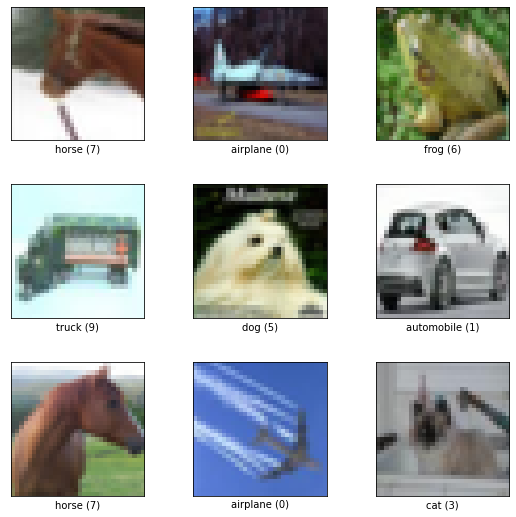

In [ ]:
fig = tfds.show_examples(test_ds, ds_info)

In [ ]:
size = test_ds.cardinality().numpy()
print(size)

10000


In [ ]:
test_images, test_labels = [None] * size, [None] * size
for i, data in enumerate(test_ds.take(size)):
    test_images[i] = data["image"]
    test_labels[i] = data["label"]
test_ds=tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [ ]:
test_ds = (test_ds
                  .map(lambda x, y: (tf.image.per_image_standardization(x), y))
                  .shuffle(buffer_size=10000)
                  .batch(batch_size=40, drop_remainder=True))

In [ ]:
loaded_model.evaluate(test_ds)

250/250 [==============================] - 36s 143ms/step - loss: 1.4379 - accuracy: 0.4836


[1.4378708600997925, 0.483599990606308]